In [ ]:
import numpy as np
import numpy as np
import numba
import matplotlib.pyplot as plt

# If you do not use Google colab, comment out the import below
from google.colab import files

In [ ]:
dt = 0.1 # ms 0.1ms is reasonable
duration = 3500  # Simulation duration (ms)
seed = 0  # seed for RNG of noise and ICs
T = duration
t = np.arange(0,T,dt)

# neural mass model parameters
tau_u = 10   # excitatory time constant
tau_p = 10   # PV time constant
tau_s = 10   # SST time constant
tau_d1 = 1500 # replenishment time constant
tau_d2 = 20   # depletion time constant
t0 = 300
dur = 100
isi = 300

w_ee = 1.1 # local E-E coupling
w_ep = 2.  # local E-PV coupling
w_es = 1.  # local E-SST coupling
w_pe = 1.  # local PV-E coupling
w_pp = 2.  # local PV-PV coupling
w_ps = 2.  # local PV-SST coupling
w_se = 6.  # local SST-E coupling
w_sp = 0.  # local SST-PV coupling
w_ss = 0.  # local SST-SST coupling
r_u = 3.  # excitatory gain
r_p = 3.  # PV gain
r_s = 3.  # SST gain
u_th = 0.7 # excitatory firing threshold
p_th = 1.0  # PV firing threshold
s_th = 1.0  # SST firing threshold
q = 5  # input amplitude

opt_pv  = -2 # optogenetic PV suppression variable
opt_sst = -1 # optogenetic SST suppression variable


g = np.ones((len(t))) # depressing term, g = D for three unit model
I_ext = np.zeros((len(t))) #Input   
I = np.zeros((len(t))) #Thalamic adapted input I_ext * g

In [ ]:
# Functions for input and optogenetic stimulation

def thalamic_input(t, dt, input_time, tau_q = 10, q = 1.3):
    I_t = np.zeros(len(t))
    for i in range(1,len(t)):
        I_t[i] = I_t[i-1] + (dt/tau_q) * (-I_t[i-1])
        for j in range(len(input_time)):
            if t[i]==input_time[j]:
                I_t[i] =q
    return I_t

def I_opto(t,laser_on_times,val=-1):
    I_opto = np.zeros((len(t)))
    laser_on_times = np.asarray(laser_on_times)*10
    for i in range(len(laser_on_times)):
        I_opto[laser_on_times[i][0]:laser_on_times[i][1]] = val
    return I_opto

In [ ]:
#Rectifying 
def f(x, r):
    if x<=0:
        return 0
    elif x<=1/r:
        return r*x
    else:
        return 1

In [ ]:
def single_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,Iopt_PV,Iopt_SST,opt_gen_flag):
    u= np.zeros((len(t)))
    p= np.zeros((len(t)))
    s= np.zeros((len(t)))
    g= np.ones((len(t)))
    
    # Note: Positive optogenetic numbers correspond to activation and negative numbers correspond to inactivation       
    for i in range(len(t)-1):
        g[i+1] = g[i] + dt * (((1-g[i])/tau_d1)-((g[i] * I_ext[i])/tau_d2))
        u[i+1] = u[i] + (-u[i] + f(w_ee*u[i] - w_ep*p[i] - w_es*s[i] + q*g[i]*I_ext[i]  - u_th,r_u))*dt/tau_u
        p[i+1] = p[i] + (-p[i] + f(w_pe*u[i] - w_pp*p[i] - w_ps*s[i] + Iopt_PV[i] + q*g[i]*I_ext[i] - p_th,r_p))*dt/tau_p
        s[i+1] = s[i] + ( -s[i] + f(w_se*u[i] - w_sp*p[i] - w_ss*s[i] + Iopt_SST[i] - s_th,r_s))*dt/tau_s
    return g,u,p,s

In [ ]:
input_tones = [100]
I_ext = thalamic_input(t, dt, input_tones, tau_q = 10, q = 5.0)
opt_pv = np.zeros((len(t)))
opt_sst = np.zeros((len(t)))
g,u,p,s = single_unit_simulation(t,dt,tau_d1,tau_d2,w_ee,w_ep,w_es,w_pe,w_pp,w_ps,w_se,w_sp,w_ss,q,I_ext,u_th,p_th,s_th,r_u,r_p,r_s,tau_u,tau_p,tau_s,opt_pv,opt_sst,opt_gen_flag=0)

tt = (t-100.)/1000.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

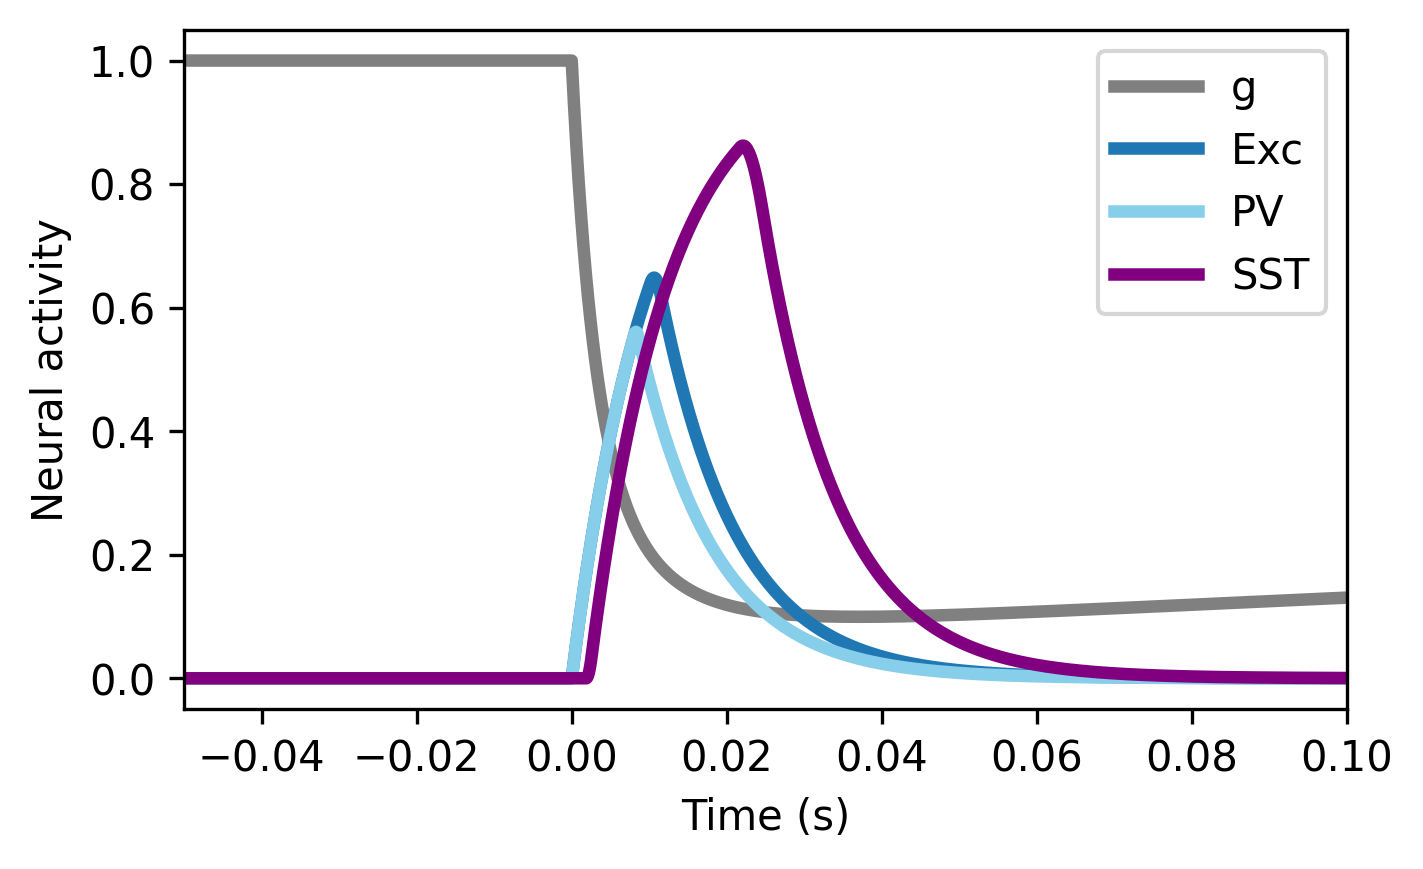

In [ ]:
#Fig 1. A. Model of the PV-SST-Exc circuit

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
plt.plot(tt,g,label="g",linewidth=3.0,color="Gray")
plt.plot(tt,u,label="Exc",linewidth=3.0)
plt.plot(tt,p,label="PV",linewidth=3.0,color="skyblue")
plt.plot(tt,s,label="SST",linewidth=3.0,color="purple")
plt.xlabel("Time (s)")
plt.ylabel("Neural activity")

plt.xlim([-0.05,0.1])
plt.legend()

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
plt.savefig('Fig1-B1.png', dpi=100,bbox_inches = "tight")
files.download('Fig1-B1.png')

plt.show()  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

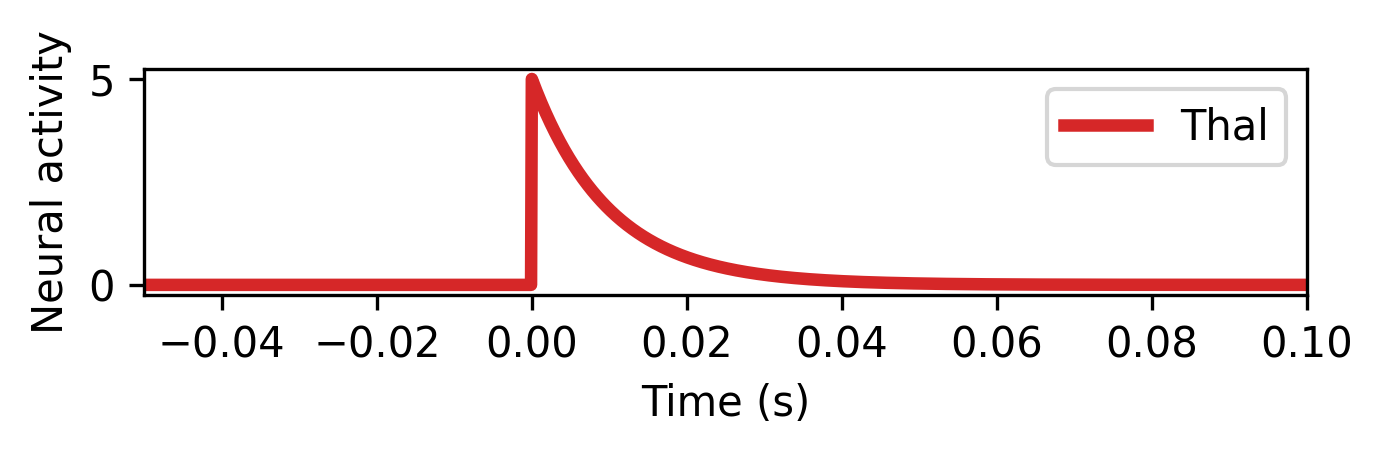

In [ ]:
#Fig 1. A. Model of the PV-SST-Exc circuit

fig, ax = plt.subplots(figsize=(5, 1), dpi=300)

plt.plot(tt,I_ext,label="Thal",linewidth=3.0, color="tab:red")
plt.xlabel("Time (s)")
plt.ylabel("Neural activity")
plt.xlim([-0.05,0.1])
plt.legend()

# If you do not use Google colab, comment out the following two lines and 
# add a line to save the plot
plt.savefig('Fig1-B2.png', dpi=100,bbox_inches = "tight")
files.download('Fig1-B2.png')

plt.show()  